Welcome to the first lab module of the RL course! This notebook is uploaded to canvas, but is mainly hosted on GitHub at [my repo](https://github.com/yusenz/RL_course.git), which currently contains this lab module and the docker scripts for the server. You can pull the repo in colab instead of manually uploading the notebook, or run things locally.

## Install Dependencies
This module is used for colab notebook on google, skip if you are using the provided container or your own environment
Based on stable baseline zoo notebook: https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/rl-baselines-zoo.ipynb 

To start with colab, you need to click the "connect" button on the top right corner to allocate a VM for the notebook, you would want to change to GPU if it shows CPU - it does not matter for the simple algorithms in this module but it would matter later. 

Then you can run the following cells to install the dependencies. It should take 2~3 minutes to finish. Run the next cell to check if GPU is enabled.

Alternatively, you can run the `./run_docker.sh` script in the git repo to pull a docker container with all the dependencies installed. You would need to have docker installed on your machine (or podman, or you can reach out to me if you want to use apptainer on BMI cluster). But this should be a lot easier than setting up the environment manually. The run docker script will start a jupyter notebook server on your local machine, with the address and login token printed in terminal stdout. You can then copy the address and paste it in your browser or your IDE ipykernel selection to execute the notebook.

In [ ]:
## Only run this cell if you are using Google Colab
## Skip with docker container
## Technically you can run these commands on your local (linux distro with apt) machine to have things installed in local environment, preferrably using conda or python venv, but overall not recommended

!apt-get update && apt-get install swig cmake ffmpeg freeglut3-dev xvfb
!git clone https://github.com/DLR-RM/rl-baselines3-zoo
%cd /content/rl-baselines3-zoo/
%pip install -r requirements.txt
%cd /content/
!git clone https://github.com/yusenz/gym-maze.git
%cd /content/gym-maze
%pip install .
%cd /content/
%pip install opencv-python-headless

In [1]:
# sanity testing to see if you have gpu setup correctly
# Should display True, 0, and the name of your GPU or some Tesla device on Colab
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
0
NVIDIA GeForce RTX 4060 Laptop GPU


## Section 1: The environment
As we discussed in the beginning of the course, as well as what you have seen in the first assignment, before we rush to fancy RL algorithms, it is important to understand the problem we are trying to solve. In common baseline environments, these can be already defined for us. However, for practical application, we need to figure out what are the observable states, what are the actions we can take, and design a reward function that will guide the agent to the desired behavior. 
The most commonly used environment interface in RL research is the OpenAI Gym or the following Gymnasium, and almost all RL implementations can utilize this interface. For practical applications, you may need to write gym wrapper for your own environment, or implement a different control flow due to gym limitations. For now, we will stick to the gym interface. For those who are familiar with older gym versions, we are using gym 0.26.2 here, with `env.step()` returning `state, reward, terminated, truncated, info` instead of `state, reward, done, info`. Also, A LOT of available environments on the internet are using older gym versions, so be careful when you are using them, or fork and manually update the environment. 
In this lab module, we will be using a 2d maze environment slightly modified from [the original repo](https://github.com/MattChanTK/gym-maze) updated for newer gym version and ipython notebook compatibility. The next cell is the description of the environment adapted from the README of the original repo.

### Environment Details
A simple 2D maze environment where an agent (blue dot) finds its way from the top left corner (blue square) to the goal at the bottom right corner (red square). 
The objective is to find the shortest path from the start to the goal.

<kbd>![Simple 2D maze environment](http://i.giphy.com/Ar3aKxkAAh3y0.gif)</kbd>

#### Action space
The agent may only choose to go up, down, right, or left ("N", "S", "E", "W"; or alternatively: 0, 1, 2, 3). If the way is blocked, it will remain at the same the location. 

#### Observation space
The observation space is the (x, y) coordinate of the agent. The top left cell is `[0. 0.]`, and the bottom right cell is `[size-1, size-1]`.

#### Reward
A reward of 1 is given when the agent reaches the goal. For every step in the maze, the agent recieves a reward of -0.1/(number of cells). This penalty can be adjusted by the `penalty=0.1` parameter, and the normalization is controlled by `penalty_normalize='size'`. I have implemented a few other normalizations: 'none', 'sqrt_size', 'log_size'. You can use `env = gym.make('maze-sample-10x10-v0',penalty=penalty,penalty_normalize=penalty_normalize)` to change the penalty and normalization.

#### End condition
The maze is reset when the agent reaches the goal (terminated), or maximum time step (10,000 for 10x10 maze) is reached (truncated). 

### Questions (with clickable answers)
Why do you think the reward needs a penalty for each step? What would happen if we don't have this penalty? What would happen if we normalize this penalty differently?
<details>
<summary>Click to reveal</summary>
 - Thinking might not be the easiest way to solve this, you can try this out with your own experimentation.
</details>

In the non backward compatible gym update, the `done` flag is replaced by `terminated` and `truncated`. The `terminated` flag is set to `True` when the agent reaches the goal, and `truncated` is set to `True` when the maximum time step is reached. Why do you think we need to differentiate between these two flags? How should the agent behave when `truncated` is `True`?
<details>
<summary>Click to reveal</summary>
 - When the agent reaches the goal, the game is finished, and the agent does not have any meaningful action or a q value to update. However, when the maximum time step is reached, the agent can still move in the future, but we cut it off for the current episode. This means that the truncated state can still have a value function. This can be more relevant with more aggressive truncation.
</details>

## Section 2: The agent
The agent is what we learn in RL. The most important aspect of the agent is that, when called by the main loop given a state, it should have the `select_action` method that returns an action - in the most basic random agent, this method will just give a random action irrespective of the state. 
The base class of the agent today is the `BaseAgent` class, which maintains the cumulative reward and the number of steps taken for the current episode if `super().init()`, `super().update_step()` and `super().update_episode()` are called in the actual implementation. Run the next cell to define the `BaseAgent` class.

In [2]:
import numpy as np
import gym
class BaseAgent:
    def __init__(self, env, verbose=1, ran_seed=42):
        self.env = env
        # random seed is only set once when the agent is initialized
        self.env.seed(ran_seed)
        self.env.action_space.seed(ran_seed+1)  # why isnt this set at env.seed?
        self.env.observation_space.seed(ran_seed+2)
        self.random_state = np.random.RandomState(ran_seed+3)
        self.observation_space = env.observation_space
        space = gym.spaces.utils.flatten_space(self.observation_space)
        # sanitize the observation space
        if isinstance(space, gym.spaces.Box):
            if space.shape is not None and len(space.shape) > 0:
                if space.is_bounded("both"):
                    high = space.high
                    low = space.low
                    self.observation_space_shape = high - low + 1
        self.action_space = env.action_space
        space = gym.spaces.utils.flatten_space(self.action_space)
        # sanitize the action space
        if isinstance(space, gym.spaces.Box):
            if space.shape is not None and len(space.shape) > 0:
                if space.is_bounded("both"):
                    high = space.high
                    low = space.low
                    self.action_space_shape = high - low + 1
        self.verbose = verbose
        self.cumulative_reward = 0
        self.num_steps = 0
    def select_action(self, state):
        raise NotImplementedError
    def update_step(self, reward: float):
        self.cumulative_reward += reward
        self.num_steps += 1
    def update_episode(self):
        self.reset_episode()
    def update_rollout(self):
        if self.verbose > 0:
            print('update_rollout in base class is called, nothing is changed')
    def update_replay(self):
        if self.verbose > 0:
            print('update_replay in base class is called, nothing is changed')
    def reset_episode(self):
        self.cumulative_reward = 0
        self.num_steps = 0


We also provide a random agent for free! The random agent will randomly choose an action from the action space. Run the next cell to define the `random_agent` class.

In [3]:
class RandomAgent(BaseAgent):
    def __init__(self, *args, **kwargs):
        self.cumulative_reward = 0
        super().__init__(*args, **kwargs)
    def select_action(self, state):
        action = self.action_space.sample()
        if self.verbose > 1:
            print('Random agent selected action: ', action)
        return action
    def update_step(self, old_state, action, reward, new_state):
        super().update_step(reward)
    def update_episode(self, terminated, truncated):
        if self.verbose > 0:
            if terminated:
                print('Episode terminated')
            if truncated:
                print('Episode truncated')
        super().update_episode()
    def update_rollout(self):
        pass
    def update_replay(self):
        pass

## Section 3: The training loop
Now that we have the environment and the agent, we can construct the main loop that let the agent interact with the environment, and let the agent learn from the interaction - although in the case of the random agent, it will not learn anything.
Run the next cell to define the main loop that let the random agent interact with the environment for a maximum of 200,000 steps with a 10x10 maze for no more than 100 episodes. With default settings, the random agent will usually time out but occasionally reach the goal. You can try the more aggressive truncation as shown in the commented out code so that you can plot the reward with more episodes - but the agent will likely not reach the goal at all in this case. To demonstrate this effect of cut off, the reward is plotted both against the number of steps and the number of episodes. For random agent, it does not learn and this plot will look like noise. However, for an agent that learns, the reward should increase over time - or you messed up somewhere.
This block of code is also used for all the following agents by changing the agent class.

In [4]:
import gym
import gym_maze
import numpy as np
import sys
from matplotlib import pyplot as plt
import IPython.display as display
import cv2


def main_loop(agent, args):
    ## experiment parameters
    # Training terminates on either reaching NUM_EPISODES or MAX_STEPS_TOTAL
    NUM_EPISODES = args['NUM_EPISODES']
    MAX_STEPS_TOTAL = args['MAX_STEPS_TOTAL']
    RENDER_MAZE = args['RENDER_MAZE']
    RENDER_EVERY = args['RENDER_EVERY']  # render every RENDER_EVERY episode because rendering can be slow
    verbose = args['verbose']
    display_handle = args['display_handle']

    ## environment
    env = args['env']
    obv = env.reset()
    directions = ['N', 'E', 'S', 'W']
    # if RENDER_MAZE:
    #     env.render()

    ## additional parameter initialization
    total_steps = 0
    cumulative_reward_array = []
    num_steps_array = []

    ## main loop
    for episode in range(NUM_EPISODES):
        new_obv = env.reset()
        # truncation is handled by the gym environment
        for step in range(MAX_STEPS_TOTAL):
            total_steps += 1
            old_obv = new_obv
            # flatten the states for the agent
            old_obv = gym.spaces.utils.flatten(env.observation_space, old_obv)
            action = agent.select_action(old_obv)
            if np.any(action ==np.array([0,1,2,3])):
                action = int(action)  # needs to be explicitly converted to int

            if verbose > 1:
                print('Selected action: ', action)
            new_obv, reward, terminated, truncated, info = env.step(action)
            if RENDER_MAZE and episode % RENDER_EVERY == 0:
                frame = env.render(mode="rgb_array")
                # ipython display DOES NOT support rgb_array which should literally be bitmap
                # turns out they dont support bitmap either
                # bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                bgr_frame = frame[:, :, ::-1]
                bgr_frame = cv2.resize(bgr_frame, (320, 320))
                _, frame_png = cv2.imencode('.png', bgr_frame)
                frame_bytes = frame_png.tobytes()
                display_handle.update(display.Image(data=frame_bytes))
            new_obv = gym.spaces.utils.flatten(env.observation_space, new_obv)
            agent.update_step(old_obv, action, reward, new_obv)
            if terminated or truncated:
                print(f'Episode {episode} finished after {int(agent.num_steps)} steps with total reward {agent.cumulative_reward}')
                cumulative_reward_array.append(agent.cumulative_reward)
                num_steps_array.append(agent.num_steps)
                agent.update_episode(terminated, truncated)
                break
            if total_steps >= MAX_STEPS_TOTAL:
                break
        if total_steps >= MAX_STEPS_TOTAL:
            break
        
    plt.plot(cumulative_reward_array)
    plt.title(f'Cumulative reward per episode for agent {agent.__class__.__name__}')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative reward')
    plt.show()

    # plot against number of steps spent
    num_steps_cumulative = np.cumsum(num_steps_array)
    plt.plot(num_steps_cumulative, cumulative_reward_array)
    plt.title(f'Cumulative reward against number of steps for agent {agent.__class__.__name__}')
    plt.xlabel('Number of steps')
    plt.ylabel('Cumulative reward')
    plt.show()
    return cumulative_reward_array, num_steps_array



Then, run the next cell to see the random agent in action. The rendering may cause display surface quit error, or just refuse to display the maze, rerunning the cell usually fixes these. The rendering is also inherently slow, so you may want to set `'RENDER_MAZE': False` or increase `'RENDER_EVERY'` in the `args` dictionary to speed up the training. However, you do want to render it occasionally to see if the agent is doing anything unexpected.

The reward data is saved here in `reward_random`, `num_steps_random` in case you want to compare your later agents with the random agent.

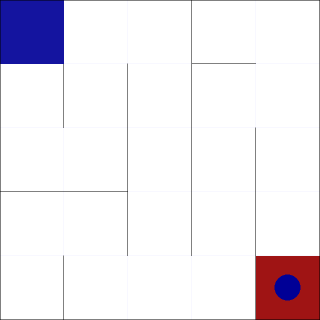

Episode 0 finished after 162 steps with total reward 0.35599999999999954
Episode terminated
Episode 1 finished after 223 steps with total reward 0.11199999999999932
Episode terminated
Episode 2 finished after 648 steps with total reward -1.5880000000000019
Episode terminated
Episode 3 finished after 513 steps with total reward -1.0480000000000014
Episode terminated
Episode 4 finished after 142 steps with total reward 0.4359999999999996
Episode terminated
Episode 5 finished after 282 steps with total reward -0.12400000000000078
Episode terminated
Episode 6 finished after 1669 steps with total reward -5.671999999999708
Episode terminated
Episode 7 finished after 189 steps with total reward 0.24799999999999944
Episode terminated
Episode 8 finished after 123 steps with total reward 0.5119999999999996
Episode terminated
Episode 9 finished after 942 steps with total reward -2.764000000000003
Episode terminated
Episode 10 finished after 2236 steps with total reward -7.9399999999994595
Episode

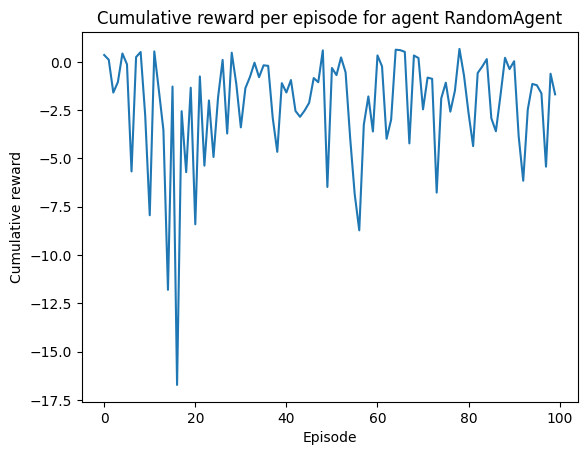

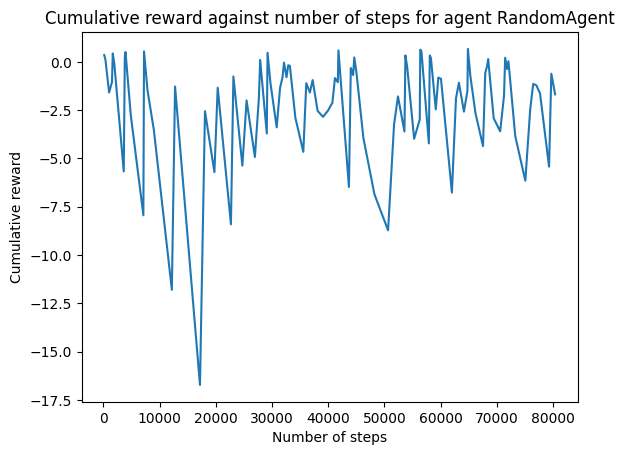

In [5]:
ran_seed = 42
env_args = {
    'max_episode_steps': 10000,
    'penalty': 0.1,
    'penalty_normalize': 'size',
    'screen_size': (640, 640)
}
env = gym.make('maze-sample-5x5-v0', **env_args)
env.seed(ran_seed)
args = {
    'env': env,
    'NUM_EPISODES': 100,
    'MAX_STEPS_TOTAL': 200000,
    'RENDER_MAZE': True,
    'RENDER_EVERY': 10,
    'verbose': 1,
    'display_handle': display.display(None, display_id=True)
}
agent = RandomAgent(env, ran_seed=ran_seed)
reward_random, num_steps_random = main_loop(agent, args)

## Section 4: Monte Carlo with state value function
We have shown that we can successfuly run the most basic random agent with the environment. Now, let us code an agent that can actually learn something. Since we are dealing with an episodic problem, we start with Monte Carlo methods. We will implement the Monte Carlo method with state value function.
### Storing the trajectory
Monte Carlo method need to store the full trajectory of the episode. This can be done by storing the visited states and actions at each step. 

This trajectory is initialized in `__init__` with `self.trajectory = []`. 

How should we store the visited states and actions at each step in `update_step`? 

We have a `reset_episode` method that is called at the beginning of each episode, do we need to do anything there?
### Value function
To update the state value function, Monte Carlo methods learn from the full episode. This means that the agent should only update the value function after the episode is finished in `update_episode`. But you do want to store the visited states and actions at each step in `update_step`. 
#### Initializing the value function
The shape of the observation space is implemented in the base agent for any gym environment with an observation space capable of being flattened to a bounded box. In our case, `self.observation_space.shape` is `array([10,10])`. The storage is initialized in `__init__` with `self.value_function = np.ones(self.observation_space.shape)*initial_value`, and the count is initialized with `self.value_count = np.ones(self.observation_space.shape)*initial_count`.

What do you think the `initial_value` should be? We have it set to 0. What would happen if we set it to a positive number? What would happen if we set it to a very negative number? Would it encourage exploration? Would it encourage exploitation? You can try this out with your own experimentation. Keep in mind that the end reward is 1, and the penalty for each step is -0.1/(number of cells) by default.
For the `initial_count`, we set it to 0. What would happen if we set it to 10? Also, our environment is deterministic, so that each action will always lead to the same state, and this setting does not matter too much. For a random environment where the same action does not always lead to the same outcome, for the previous `initial_value` to take effect, how should we adjust the `initial_count`?
#### Handling terminational state
One caveat of state value function is that the actual terminal state needs to have a value function so that the agent will end the episode instead of reaping maximum value hanging around close to the goal. You need to make sure that the terminal state has a value function greater than whatever is close by.

#### Calculating return
For Monte Carlo method, we need to calculate the return beginning from the end of episode backwards through the full trajectory. The return can be recursively calculated as `return = reward + discount_factor * return`. The discount factor is another knob that you can tune here. Would tuning it to 0 make the agent fullly greedy?

#### Updating the value function
In Monte Carlo, the value function is the average of all historical returns and the new updated return. Given the current visited count of the state in `self.value.count`, you can figure the math out. And remember to update the count as well! 

There is a slight difference between the first visit and every visit Monte Carlo methods. The first visit method only updates the value function when the state is visited for the first time in the episode. The every visit method updates the value function every time the state is visited in the episode. You can implement either. Although it would be nicer if you can implement both using the `self.first_visit` flag.

### Policy
With a state value function, we can choose our action based on the state value function. I put in place a simple epsilon greedy policy for you to use, although you still need to implement how to choose the action to maximize the value function. You also need to think about how to break ties when multiple actions have the same value function - basically at the beginning.

Reminder: the starting state at top left is `[0,0]`, and the goal state at bottom right is `[size-1,size-1]`, and the action space is `["N", "S", "E", "W"]` (corresponding to up, down, right, left) or `[0, 1, 2, 3]`.

The epsilon is another knob that you can tune here. Would tuning it to 0 make the agent fully greedy? What if you set up the `initial_value` and `initial_count` to something non 0?

Also, our environment is deterministic. Think about how you are determining the action here, does this make our agent technically model-based? Is a model-free agent with value function instead of a q function possible?
### Implementation
Fill in the blanks into the next block to define the Monte Carlo agent, then run the following block to see the Monte Carlo agent in action.

In [120]:
mc_results = []
class MonteCarloStateValueAgent(BaseAgent):
    def __init__(self, *args, discount_factor=1, epsilon=0, initial_value = 0, initial_count = 1, first_visit = False, **kwargs):
        super().__init__(*args, **kwargs)  # we rely on parent class for some initialization, call it first
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.trajectory = []
        self.value_function = np.ones(self.observation_space_shape) * initial_value
        self.value_count = np.ones(self.observation_space_shape) * initial_count
        self.first_visit = first_visit
    def update_step(self, old_state, action, reward, new_state):
        ### We want to store the visited states, actions and rewards for each step into self.trajectory here. How?





        ## keep this for cumulative reward
        super().update_step(reward)
    def update_episode(self, terminated, truncated):
        ## termination: make sure the value function of the terminal state makes sense compared to the surroundings 
        if terminated:
            pass

        
        ## for first visit, we are calculating return backwards, how do we check if it is the first visit?
        ## hint: np arrays behave weirdly with x in y


        ## We probably want to use a loop over the trajectory, do you want a for loop or a while loop?
        while False:
            state_to_update = [0, 0] 
            state_to_update = tuple(state_to_update) # Placeholder, but if you want to use it to index the value function, it needs to have this shape and be a tuple
            value_old = self.value_function[state_to_update]
            count_old = self.value_count[state_to_update]

            ## calculate the return

            ## update the value function and value count




        if self.verbose > 0:
            if terminated:
                print('Episode terminated')
            if truncated:
                print('Episode truncated')
        super().update_episode()  # this will call reset_episode, so we probably want it to be the last thing
    def reset_episode(self):
        ### Do we want to clean up anything here?




        super().reset_episode()
    def select_action(self, state):
        if self.random_state.rand() < self.epsilon:
            action = self.action_space.sample()
        else:
            ## We want to select the action that maximizes the value function here. How?
            ## There needs to be a tie breaker, how do you want to break the tie?
            pass



            ## this will return True if the action goes through without hitting a wall, False otherwise, I will leave it here for you to use
            if not isinstance(action, int):  ## NSEW action
                is_open = self.env.maze_view.is_open(state, action)
            else:
                is_open = self.env.maze_view.is_open(state, self.env.ACTION[action])





        
        if self.verbose > 1:
            print('Monte Carlo agent selected action: ', action)
        return action

Here goes the experiment! Remember that you are supposed to tune some of the parameters. To run multiple experiments and do not overwrite, copy and run the cell multiple times. The result is stored in the `mc_reward` variable for each repeat.

Also, this agent is fairly likely to be stuck in local minima. You have been warned. Try changing the seed if things are not working out. Or if you increase epsilon to 1, you should be as 'good' as the random agent.

In [ ]:
ran_seed = 42
env_args = {
    'max_episode_steps': 10000,
    'penalty': 0.1,
    'penalty_normalize': 'size',
    'screen_size': (640, 640)
}
env = gym.make('maze-sample-5x5-v0', **env_args)
env.seed(ran_seed)

agent_kwargs = {
    'env': env,
    'verbose': 1,
    'discount_factor': 0.9,
    'epsilon': 0.2,
    'initial_value': 0,
    'initial_count': 0,
    'ran_seed': ran_seed,
    'first_visit': False
}
agent = MonteCarloStateValueAgent(**agent_kwargs)

args = {
    'env': env,
    'NUM_EPISODES': 100,
    'MAX_STEPS_TOTAL': 1000000,
    'RENDER_MAZE': False,
    'RENDER_EVERY': 5,
    'verbose': 1,
    'display_handle': display.display(None, display_id=True)
}
reward_mc, num_steps_mc = main_loop(agent, args)
# for debugging
print(agent.value_function)
print(agent.value_count)
mc_results.append([ran_seed, env_args, args, agent_kwargs, reward_mc, num_steps_mc])

### Questions recap from this section (without answers, and you should answer them here)
#### Q1
What do you think the `initial_value` should be? We have it set to 0. What would happen if we set it to a positive number? What would happen if we set it to a very negative number? Would it encourage exploration? Would it encourage exploitation? You can try this out with your own experimentation. Keep in mind that the end reward is 1, and the penalty for each step is -0.1/(number of cells) by default.

Your answer here
#### Q2
For the `initial_count`, we set it to 0. What would happen if we set it to 10? Also, our environment is deterministic, so that each action will always lead to the same state, and this setting does not matter too much. For a random environment where the same action does not always lead to the same outcome, for the previous `initial_value` to take effect, how should we adjust the `initial_count`?

Your answer here
#### Q3
For Monte Carlo method, we need to calculate the return beginning from the end of episode backwards through the full trajectory. The return can be recursively calculated as `return = reward + discount_factor * return`. The discount factor is another knob that you can tune here. Would tuning it to 0 make the agent fullly greedy?

Your answer here
#### Q4
For the epsilon greedy policy, the epsilon is another knob that you can tune here. Would tuning it to 0 make the agent fully greedy? What if you set up the `initial_value` and `initial_count` to something non 0?

Your answer here
#### Q5
Also, our environment is deterministic. Think about how you are determining the action here, does this make our agent technically model-based? Is a model-free agent with value function instead of a q function possible?

Your answer here

## Section 5: Monte Carlo with action value function
You may have noticed that the agent need to look into the environment a little bit to determin the action based on state value function. And if you enabled render (and render worked), you may see agent stuck bouncing between two or a few states in an infinite loop - because the agent is choosing while trying to optmize for the state action value and that is possible to create a loop of optimalities between two states. 

So, a more common approach is to use the action value function, or more commonly called, q function, instead of the state value function. The q function is the value function of the state action pair, and it is easier to determine the action based on the action value function. However, the space is now size of action space times larger, and you can see how it may not work for larger problem with larger action space.

Also, you may think the action space size in this problem is 4, but in gym implementation it is actually... $2^4 = 16$. Because the 4 actions are distinct and does not make sense to be combined into one dimension, especially when we deal with function approximators later. Instead, gym by default encode discrete action space like this into a one-hot vector. Now you may argue that it would make more sense to have a $3\times3=9$ action space, because North is negative South and East is negative West. But then you need to use a proper box action space and not just flatten a discrete action space - you are welcomed to modify the repo of the environment, and make sure everything still works.

### Implementation
You can almost copy all the code above - I implemented the shape of value function storage to be `tuple(list(self.observation_space_shape)+list(self.action_space_shape))`. You just need to connect the state and action into a list of length 6 (`state_action_to_update`), and convert it back to a tuple to index the value function. 

You do not even need to worry about the termination now since termination reward is properly assigned to the last state action pair comparing to the second last state in state value function. 

And policy should now just be the maximum of all the action value function at the state without peeking into the environment. Do remember that we are using a one-hot vector for action space, you need a conversion between that and int, and that not everything in the one-hot vector is a valid action..

In [ ]:
mc_action_results = []
class MonteCarloActionValueAgent(BaseAgent):
    def __init__(self, *args, discount_factor=1, epsilon=0, initial_value = 0, initial_count = 1, first_visit = False, **kwargs):
        super().__init__(*args, **kwargs) 
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.trajectory = []
        value_shape = list(self.observation_space_shape) + list(self.action_space_shape)
        self.value_function = np.ones(tuple(value_shape)) * initial_value
        self.value_count = np.ones(tuple(value_shape)) * initial_count
        self.first_visit = first_visit
    def update_step(self, old_state, action, reward, new_state):
        ### We want to store the visited states, actions and rewards for each step into self.trajectory here. How?





        ## keep this for cumulative reward
        super().update_step(reward)
    def update_episode(self, terminated, truncated):
        ## termination: make sure the value function of the terminal state makes sense compared to the surroundings 
        if terminated:
            pass

        
        ## for first visit, we are calculating return backwards, how do we check if it is the first visit?
        ## hint: np arrays behave weirdly with x in y


        ## We probably want to use a loop over the trajectory, do you want a for loop or a while loop?
        while False:
            state_to_update = [0, 0] 
            action_to_update = [0, 0, 1, 0]  # Placeholder, but you probably want to convert the action from an int to a one-hot vector - and remember python counts from 0
            state_action_to_update = tuple(state_action_to_update) # Placeholder, but if you want to use it to index the value function, it needs to have this shape and be a tuple
            value_old = self.value_function[state_action_to_update]
            count_old = self.value_count[state_action_to_update]

            ## calculate the return

            ## update the value function and value count




        if self.verbose > 0:
            if terminated:
                print('Episode terminated')
            if truncated:
                print('Episode truncated')
        super().update_episode()
    def reset_episode(self):
        ### Do we want to do anything here?




        super().reset_episode()
    def select_action(self, state):
        if self.random_state.rand() < self.epsilon:
            action = self.action_space.sample()
        else:
            ## We want to select the action that maximizes the value function here. How?
            ## There needs to be a tie breaker, how do you want to break the tie?
            pass



            ## this will return True if the action goes through without hitting a wall, False otherwise, I will leave it here for you to use
            if not isinstance(action, int):  ## NSEW action
                is_open = self.env.maze_view._MazeView2D__maze.is_open(state, action)
            else:
                is_open = self.env.maze_view._MazeView2D__maze.is_open(state, self.env.ACTION[action])





        
        if self.verbose > 1:
            print('Monte Carlo agent selected action: ', action)
        return action

In [ ]:
ran_seed = 42
env_args = {
    'max_episode_steps': 10000,
    'penalty': 0.1,
    'penalty_normalize': 'size',
    'screen_size': (640, 640)
}
env = gym.make('maze-sample-10x10-v0', **env_args)
env.seed(ran_seed)

agent_kwargs = {
    'env': env,
    'verbose': 1,
    'discount_factor': 0.99,
    'epsilon': 0.2,
    'initial_value': 0,
    'initial_count': 0,
    'ran_seed': ran_seed,
    'first_visit': False
}
agent = MonteCarloActionValueAgent(**agent_kwargs)

args = {
    'env': env,
    'NUM_EPISODES': 100,
    'MAX_STEPS_TOTAL': 1000000,
    'RENDER_MAZE': False,
    'RENDER_EVERY': 5,
    'verbose': 1,
    'display_handle': display.display(None, display_id=True)
}
reward_mc, num_steps_mc = main_loop(agent, args)
# for debugging
print(agent.value_function)
print(agent.value_count)
mc_action_results.append([ran_seed, env_args, args, agent_kwargs, reward_mc, num_steps_mc])

## Section 6: Conclusion
This should cover the basics for the first lab module. As you can see, we are (at least should be) outperforming the random agent. But things can sometimes get stuck, and if you try it on a 10x10 maze, you may see the agent not capable of reaching the goal. This is where we need to introduce some other methods. You will be implementing a few other basic methods like TD0, TD lambda, SARSA and Q-learning. We are still deciding if it will appear as another lab module, or it might be an assignment.

## Section 7: Extra
Even without changing the agent per se, we have all kinds of tricks to maybe accelerate the learning.

For example, we can use the magic of reward engineering to make things work! At least preventing the agent from going into the same square in the same episode isnt hard. Try the next block, you may want to make adjustments based on your implementation. This does mess up the cumulative reward with this implementation, feel free to fix it.

After this engineering, the agent seems to be able to work with 10x10 maze, while the base one does not, or at least I was not really able to make the base one work.

In [178]:
class EngineeredRewardAgent(MonteCarloActionValueAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.episode_visited_count = np.zeros(self.value_count.shape)
        self.value_function_momentum = np.zeros(self.value_function.shape)
    def update_step(self, old_state, action, reward, new_state):
        action_encoding = [0, 0, 0, 0]
        action_encoding[action] = 1
        state_action = tuple(list(old_state) + list(action_encoding))
        visited_count = self.episode_visited_count[state_action]
        ## this would make a whole lot more sense in TD learning
        ## but even in mc, we always 1 less step forward than backward so it probably still work
        ## not for first visit though, unless you do it yourself subtracting this in the update_episode
        reward = reward - visited_count * 0.0003
        self.episode_visited_count[state_action] += 1
        super().update_step(old_state, action, reward, new_state)
    def reset_episode(self):
        super().reset_episode()
        self.episode_visited_count = np.zeros(self.value_count.shape)

In [ ]:
# abuse your best agent with an advanced maze
ran_seed = 42
env_args = {
    'max_episode_steps': 10000,
    'penalty': 0.1,
    'penalty_normalize': 'size',
    'screen_size': (640, 640)
}
env = gym.make('maze-sample-10x10-v0', **env_args)
env.seed(ran_seed)

### use a good agent
agent_kwargs = {
    'env': env,
    'verbose': 1,
    'discount_factor': 0.99,
    'epsilon': 0.2,
    'initial_value': 0,
    'initial_count': 0,
    'ran_seed': ran_seed,
    'first_visit': False
}
agent = EngineeredRewardAgent(**agent_kwargs)


### if you enable render, you will see other colored squrares, those are portals, they will teleport you to the other portal of the same color
args = {
    'env': env,
    'NUM_EPISODES': 100,
    'MAX_STEPS_TOTAL': 1000000,
    'RENDER_MAZE': False,
    'RENDER_EVERY': 5,
    'verbose': 1,
    'display_handle': display.display(None, display_id=True)
}
reward_mc, num_steps_mc = main_loop(agent, args)
# for debugging
print(agent.value_function)
print(agent.value_count)
mc_action_results.append([ran_seed, env_args, args, agent_kwargs, reward_mc, num_steps_mc])